In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm
from functools import reduce
from lr.text_processing.util import pre_process_nli_df, get_vocab_count
from lr.text_processing.transformations.util import get_augmented_data
from lr.training.util import get_binary_label, get_ternary_label
from lr.text_processing.transformations.structural import entailment_internalization
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper
from lr.stats.matched_comparison import get_disagreement_statistics, get_matched_results
from lr.stats.bootstrap import get_bootstrap_replications, apply_transformation_under_H0
from IPython.display import HTML, display
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# load data

In [2]:
train_path = "data/toy/train.csv"
dev_path = "data/toy/dev.csv"
df = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
pre_process_nli_df(df)
pre_process_nli_df(dev)

## Creating transformation that forces difference

In [3]:
def label_internalization(df):
    df_new = df.copy()
    df_new.loc[:,"hypothesis"] = df.hypothesis + " " + df.label
    return df_new

transformation = label_internalization
# transformation = entailment_internalization

display(HTML(transformation(df.head(4)).to_html()))

,premise,hypothesis,label
0,a couple playing with a little boy on the beach,a couple are playing with a young child outside entailment,entailment
1,a man with a red shirt is watching another man who is standing on top of a attached cart filled to the top,the men are outside neutral,neutral
2,a busy city that looks like new york city,the city looks like lawrence kansas contradiction,contradiction
3,a blond woman with two children is checking out at a walmart register,a mother is with her two children at walmart buying food neutral,neutral


## Applaying transformation to a part of the data

In [4]:
df_ = get_augmented_data(df=df.head(4),
                         transformation=transformation,
                         frac=0.5)

display(HTML(df_.to_html()))

,premise,hypothesis,label
0,a couple playing with a little boy on the beach,a couple are playing with a young child outside entailment,entailment
1,a man with a red shirt is watching another man who is standing on top of a attached cart filled to the top,the men are outside neutral,neutral
2,a busy city that looks like new york city,the city looks like lawrence kansas,contradiction
3,a blond woman with two children is checking out at a walmart register,a mother is with her two children at walmart buying food,neutral


### Check `apply_transformation_under_H0`

In [5]:
original_h0, transformed_h0 = apply_transformation_under_H0(df.head(4), df_transformation_f=transformation)

print("original under h0")

display(HTML(original_h0.to_html()))
print("transformed  under h0")
display(HTML(transformed_h0.to_html()))

original under h0


,premise,hypothesis,label
0,a couple playing with a little boy on the beach,a couple are playing with a young child outside,entailment
1,a man with a red shirt is watching another man who is standing on top of a attached cart filled to the top,the men are outside neutral,neutral
2,a busy city that looks like new york city,the city looks like lawrence kansas contradiction,contradiction
3,a blond woman with two children is checking out at a walmart register,a mother is with her two children at walmart buying food,neutral


transformed  under h0


,premise,hypothesis,label
0,a couple playing with a little boy on the beach,a couple are playing with a young child outside entailment,entailment
1,a man with a red shirt is watching another man who is standing on top of a attached cart filled to the top,the men are outside,neutral
2,a busy city that looks like new york city,the city looks like lawrence kansas,contradiction
3,a blond woman with two children is checking out at a walmart register,a mother is with her two children at walmart buying food neutral,neutral


## Bootstrap hypothesis testing

In [6]:
def invert_df(df):
    new_A = df.B.values
    new_B = df.A.values
    new = pd.DataFrame({"A":new_A, "B":new_B},index=df.index)
    return new

B = 3
max_features = 500
pcts = [0.345]
label_translation = get_ternary_label

ids = [[i] * B for i in pcts]
ids = reduce(lambda x,y: x + y, ids)

boot_stats = []

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}

pct = pcts[0]
train = df.copy()
train_aug = get_augmented_data(df=train,
                               transformation=transformation,
                               frac=pct)
dev_t = transformation(dev)
lr = LRWrapper(hyperparams)
lr.fit(train_aug)
sample_pairs = get_matched_results(df=dev,
                                   df_t=dev_t,
                                   model=lr,
                                   label_translation=label_translation)

sample_pairs = sample_pairs[["A", "B"]]

def invert_df(df):
    new_A = df.B.values
    new_B = df.A.values
    new = pd.DataFrame({"A":new_A, "B":new_B},index=df.index)
    return new

def get_t_stats(df):
    A_minus_B = df.A - df.B
    mean = A_minus_B.mean()
    std = A_minus_B.std(ddof=0)
    n = df.shape[0]
    S = std / np.sqrt(n)
    t = mean / S
    return t
    
boots_replication = []
B = 6000
for b in tqdm(range(B)):
    
    boot_sample = sample_pairs.sample(frac=1, replace=True)

    old_index = list(boot_sample.index)
    boot_sample = boot_sample.reset_index(drop=True)
    boot_sample_inverted = invert_df(boot_sample.sample(frac=0.5))
    original_index  = [i for i in boot_sample.index.unique() if i not in boot_sample_inverted.index.unique()]
    half_inverted = pd.concat([boot_sample.loc[original_index],boot_sample_inverted])

    boot_t = get_t_stats(half_inverted)
    boots_replication.append(boot_t)



100%|██████████| 6000/6000 [01:59<00:00, 50.39it/s]


## Observable stats

In [7]:
get_t_stats(sample_pairs)

-26.246692913372705

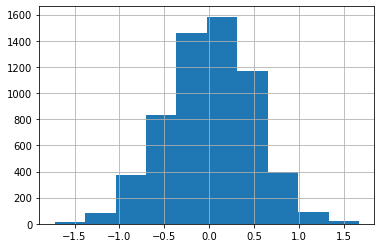

In [14]:
boot_result = pd.Series(boots_replication)
boot_result.name = "t"
boot_result = boot_result.to_frame()
boot_result.loc[:, "p_values"]  = 1 - scipy.stats.chi2.cdf(boot_result.t ** 2, df=1)
boot_result.t.hist();

In [15]:
lower_tail_f = lambda x: (boot_result.sort_values() <= x).astype(int).mean()
upper_tail_f = lambda x: (boot_result.sort_values() > x).astype(int).mean()
equal_tail_boot_p_value = lambda x: 2* np.min([lower_tail_f(x), upper_tail_f(x)])

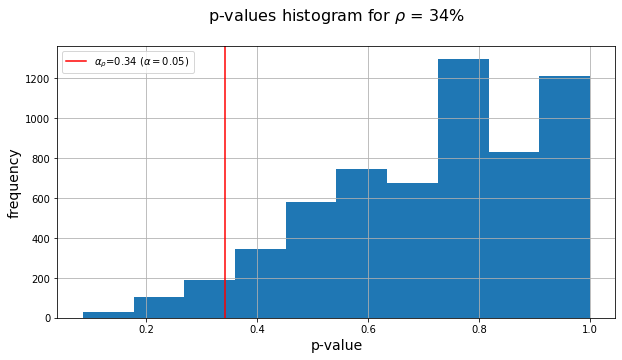

In [16]:
boot_result.loc[:, "p_values"]  = 1 - scipy.stats.chi2.cdf(boot_result.t ** 2, df=1)
alpha_t_test = 0.05
rho = pcts[0]

p_values = boot_result.p_values
alpha_rho = np.quantile(p_values.dropna(), alpha_t_test)


# for comparison
# p_values = pd.Series(np.random.uniform(0,1,B))
# alpha_rho = np.quantile(p_values, alpha_t_test)



fig, ax = plt.subplots(figsize=(10,5))
p_values.hist(ax=ax);
plt.axvline(x=alpha_rho, color='r', linestyle='-', label=r"$\alpha_\rho$={:.2f} ($\alpha = {:.2f}$)".format(alpha_rho, alpha_t_test));
ax.set_xlabel("p-value", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title(r"p-values histogram for $\rho$ = {:.0%}".format(rho) +"\n", fontsize=16)
plt.legend(loc="best");